TabNet: Attentive Interpretable Tabular Learning (for starter, <a tagret = "_blank" href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/main/notebooks/samples/explanations/ai-explanations-tabnet-algorithm.ipynb">Google Notebook)</a>

All that is pure free Open Source. You can only build and enjoy the ride.<br />
Ever so grateful

example workflow adapts to your data.
takes full benefit of grouped attention for (out-of-the-box one-hot-encoded) categorical features

<hr />

# setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys, json

In [3]:
import pandas as pd

In [4]:
from dotenv import find_dotenv
find_dotenv()

'/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/sample_pipelines/.env'

In [5]:
# WandB API key
from dotenv import load_dotenv
load_dotenv("../.env")

True

In [6]:
os.getcwd()

'/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/sample_pipelines/TabNet_hp_cv_WandB'

In [7]:
# adding custom code to path for easy imports while "ml-pipelines" is not an installed package
new_path = os.path.realpath(os.path.join(os.getcwd(),
                                         "..", ".."))
if new_path not in sys.path:
    sys.path.append(new_path)
sys.path

['/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python39.zip',
 '/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python3.9',
 '/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python3.9/lib-dynload',
 '',
 '/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python3.9/site-packages',
 '/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start']

In [8]:
import sys
os.environ['conda_env'] = os.path.basename(sys.prefix)
os.environ['conda_env']

'metaflow_pytorch_1'

In [9]:
mf_flow_name = "TabNetHpCvWandbFlow"
os.environ['pipeline_hp_grid'] = "{}"

In [10]:
import torch
print(torch.cuda.get_device_name(0))
torch.__version__

NVIDIA GeForce GTX 1060


'1.13.1.post200'

In [0]:
from IPython import get_ipython

def reset_jupyter_history():
    """
    reset cell numbering
    """

    import os
    import sqlite3
    from traitlets.config import Config
    from IPython.core.history import HistoryManager
    
    ip = get_ipython()
    
    if ip is not None:
        # Disable history temporarily
        if hasattr(ip, 'history_manager'):
            ip.history_manager.enabled = False
        
        # Get the path to the history database
        hist_file = os.path.expanduser('~/.ipython/profile_default/history.sqlite')
        if hasattr(ip, 'history_manager') and hasattr(ip.history_manager, 'hist_file'):
            hist_file = ip.history_manager.hist_file
        
        if os.path.exists(hist_file):
            # Close any existing connection
            if hasattr(ip, 'history_manager') and hasattr(ip.history_manager, 'db') and ip.history_manager.db is not None:
                ip.history_manager.db.close()
            
            # Truncate the database
            conn = sqlite3.connect(hist_file)
            conn.execute("DELETE FROM history")
            conn.execute("DELETE FROM sqlite_sequence WHERE name='history'")
            conn.commit()
            conn.close()
        
        # Create a new Config object
        c = Config()
        c.HistoryManager.hist_file = hist_file
        
        # Create a new HistoryManager instance
        new_history_manager = HistoryManager(shell=ip, config=c)
        
        # Assign the new history manager to the shell
        ip.history_manager = new_history_manager
        
        # Enable history
        ip.history_manager.enabled = True

        ip.kernel.shell.execution_count = 0
        
        print("Jupyter history has been reset.")
    else:
        print("This function must be run within a Jupyter notebook.")

reset_jupyter_history()
get_ipython().kernel.shell.execution_count

Jupyter history has been reset.


0

<hr />

# Generate data

In [7]:
from retrain_pipelines.dataset import DatasetType, pseudo_random_generate

# Define the number of samples
num_samples = 10_000 # 500 # 10 # 1_500 # 

data = pseudo_random_generate(DatasetType.TABULAR_CLASSIFICATION, num_samples)

# Display the first few rows of the dataset
print(data.head())
#data.to_csv(os.path.realpath(os.path.join('..', 'data', 'synthetic_classif_tab_data_4classes.csv')), index=False)

Classes priors: [24.8, 35.7, 25.0, 14.5]%
  categ_feature0  num_feature1  num_feature2  num_feature3  num_feature4  \
0         value1           0.3          15.8           0.3           2.2   
1         value1           0.9          63.9           3.4           4.8   
2         value9           0.4          34.6           0.4           7.8   
3         value5           3.8          23.3           6.1           2.2   
4         value6           0.1          20.6           0.0           1.3   

    target  
0  class_0  
1  class_2  
2  class_1  
3  class_1  
4  class_0  


In [ ]:
#from sklearn.preprocessing import StandardScaler, \
#                                  OneHotEncoder
#
#os.environ["ml_pipeline_type"] = "tabnet_classif_torchserve"
#
#from retrain_pipelines.model import preprocess_data_fct
#
#scaler = StandardScaler()
#encoder = OneHotEncoder(sparse_output=False, drop=None)
#pp_data = preprocess_data_fct(data, scaler, encoder,
#                    buckets={'num_feature1': [-1.002, -0.6, -0.19999999999999996, 0.20000000000000018, 0.6000000000000001, 1.0],
#                             'num_feature2': 15},
#                    is_training=True)
#
#del os.environ["ml_pipeline_type"]
#
#display(pp_data)
#display(scaler)
#display(encoder)

In [ ]:
from retrain_pipelines.dataset import features_desc
pd.DataFrame([features_desc(data)])

In [ ]:
from retrain_pipelines.dataset import features_distri_plot
display(features_distri_plot(data))

In [ ]:
from retrain_pipelines.dataset.features_dependencies import dataset_to_heatmap_fig
heatmap_fig, ax = dataset_to_heatmap_fig(data)
heatmap_fig.patch.set_facecolor((1.0, 1.0, 1.0, 0.6))
display(heatmap_fig)

<hr />

# TabNet

In [12]:
pipeline_hp_grid = {
    "trainer": {
        "max_epochs":[30, 50], #sys.maxsize,
        "patience":[100],
        "batch_size":[1024],
        "virtual_batch_size":[256],
    },
    "model": {
        "n_d":[64],
        "n_a":[64],
        "n_steps":[5],
        "gamma":[1.5],
        "n_independent":[2],
        "n_shared":[2],
        "lambda_sparse":[1e-4],
        "momentum":[0.3],
        "clip_value":[2.],
        "optimizer_fn":["torch.optim.Adam"],
        "optimizer_params":[dict(lr=2e-2)],
        "scheduler_params":[{"gamma": 0.80,
                            "step_size": 20}],
        "scheduler_fn":["torch.optim.lr_scheduler.StepLR"],
        "epsilon":[1e-15]
    }
}

In [13]:
from textwrap import dedent
#os.environ['pipeline_hp_grid'] = str(json.dumps(dedent("""{pipeline_hp_grid}""".format(pipeline_hp_grid=pipeline_hp_grid))))
#print(os.environ['pipeline_hp_grid'])
os.environ['pipeline_hp_grid'] = str(json.dumps(dedent("""{pipeline_hp_grid}""".format(pipeline_hp_grid=pipeline_hp_grid)))).replace("'", '"').strip('"')
print(os.environ['pipeline_hp_grid'])

{"trainer": {"max_epochs": [30, 50], "patience": [100], "batch_size": [1024], "virtual_batch_size": [256]}, "model": {"n_d": [64], "n_a": [64], "n_steps": [5], "gamma": [1.5], "n_independent": [2], "n_shared": [2], "lambda_sparse": [0.0001], "momentum": [0.3], "clip_value": [2.0], "optimizer_fn": ["torch.optim.Adam"], "optimizer_params": [{"lr": 0.02}], "scheduler_params": [{"gamma": 0.8, "step_size": 20}], "scheduler_fn": ["torch.optim.lr_scheduler.StepLR"], "epsilon": [1e-15]}}


In [14]:
from retrain_pipelines.utils import dict_dict_list_get_all_combinations

# Get all possible combinations
all_hp_combinations = dict_dict_list_get_all_combinations(pipeline_hp_grid)
# pick first
all_hp_combinations[0]

{'trainer': {'max_epochs': 30,
  'patience': 100,
  'batch_size': 1024,
  'virtual_batch_size': 256},
 'model': {'n_d': 64,
  'n_a': 64,
  'n_steps': 5,
  'gamma': 1.5,
  'n_independent': 2,
  'n_shared': 2,
  'lambda_sparse': 0.0001,
  'momentum': 0.3,
  'clip_value': 2.0,
  'optimizer_fn': torch.optim.adam.Adam,
  'optimizer_params': {'lr': 0.02},
  'scheduler_params': {'gamma': 0.8, 'step_size': 20},
  'scheduler_fn': torch.optim.lr_scheduler.StepLR,
  'epsilon': 1e-15}}

In [15]:
from pytorch_tabnet.tab_model import TabNetClassifier

if 'target' in data:
    y = data.pop('target')
y.unique()

array(['class_2', 'class_0', 'class_1', 'class_3'], dtype=object)

In [16]:
from sklearn.preprocessing import StandardScaler, \
                                  OneHotEncoder
os.environ["ml_pipeline_type"] = "mf_tabnet_classif_torchserve"
from ml_pipelines.model import preprocess_data_fct

scaler = StandardScaler()
encoder = OneHotEncoder(sparse_output=False, drop=None)
buckets={'num_feature1': 5}
grouped_features = []
X_transformed = preprocess_data_fct(data, scaler, encoder,
                                    buckets=buckets,
                                    grouped_features=grouped_features,
                                    is_training=True)
len(X_transformed.columns), X_transformed.columns

buckets_dict : {'num_feature1': [-0.0871, 17.419999999999998, 34.839999999999996, 52.25999999999999, 69.67999999999999, 87.1]}
encoder_dict : {'categ_feature0': ['value1', 'value2', 'value3', 'value4', 'value5', 'value6', 'value7', 'value8', 'value9'], 'bucketized_num_feature1': ['bucket1', 'bucket2', 'bucket3', 'bucket4', 'bucket5']}
grouped_features : [[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13]]
scaler_dict : {'mean': [28.26166, 2.9746200000000003, 6.9202699999999995], 'std_dev': [19.058544751486142, 2.6654729140623434, 33.64979352280041]}


(17,
 Index(['categ_feature0_value1', 'categ_feature0_value2',
        'categ_feature0_value3', 'categ_feature0_value4',
        'categ_feature0_value5', 'categ_feature0_value6',
        'categ_feature0_value7', 'categ_feature0_value8',
        'categ_feature0_value9', 'bucketized_num_feature1_bucket1',
        'bucketized_num_feature1_bucket2', 'bucketized_num_feature1_bucket3',
        'bucketized_num_feature1_bucket4', 'bucketized_num_feature1_bucket5',
        'num_feature2_scaled', 'num_feature3_scaled', 'num_feature4_scaled'],
       dtype='object'))

In [17]:
clf = TabNetClassifier(
    **all_hp_combinations[0]['model'],
    grouped_features=grouped_features
)

/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [18]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(
    range(len(X_transformed)), test_size=0.2, random_state=0)

X_train = X_transformed.values[train_idx]
y_train = y.values[train_idx]
X_valid = X_transformed.values[test_idx]
y_valid = y.values[test_idx]

In [19]:
from pytorch_tabnet.callbacks import Callback
import wandb

class PrintLR(Callback):
    def __init__(self):
        self.previous_lr = None

    def on_epoch_end(self, epoch, logs=None):
        current_lr = self.trainer.optimizer_params['lr']
        if self.previous_lr is None or current_lr != self.previous_lr:
            print(f"Epoch {epoch+1}: Learning rate changed to {current_lr:.6f}")
        self.previous_lr = current_lr

class WandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        wandb.log({"epoch": epoch + 1, **logs})

    def on_train_end(self, logs=None):
        wandb.finish()

In [20]:
#help(clf.fit)

In [21]:
clf.fit(
    X_train=X_train, y_train=y_train,
    loss_fn=torch.nn.CrossEntropyLoss(),
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    **all_hp_combinations[0]['trainer'],
    augmentations=None,
    drop_last=False,
    callbacks=[PrintLR()]#, WandbCallback]
)

epoch 0  | loss: 1.11493 | train_accuracy: 0.76512 | valid_accuracy: 0.7745  |  0:00:00s
Epoch 1: Learning rate changed to 0.020000
epoch 1  | loss: 0.59974 | train_accuracy: 0.7845  | valid_accuracy: 0.7905  |  0:00:01s
epoch 2  | loss: 0.5582  | train_accuracy: 0.7725  | valid_accuracy: 0.7865  |  0:00:02s
epoch 3  | loss: 0.51137 | train_accuracy: 0.76825 | valid_accuracy: 0.7765  |  0:00:03s
epoch 4  | loss: 0.48597 | train_accuracy: 0.80988 | valid_accuracy: 0.8185  |  0:00:03s
epoch 5  | loss: 0.47276 | train_accuracy: 0.76262 | valid_accuracy: 0.772   |  0:00:04s
epoch 6  | loss: 0.46877 | train_accuracy: 0.801   | valid_accuracy: 0.806   |  0:00:05s
epoch 7  | loss: 0.47039 | train_accuracy: 0.80638 | valid_accuracy: 0.8115  |  0:00:06s
epoch 8  | loss: 0.45917 | train_accuracy: 0.80338 | valid_accuracy: 0.8065  |  0:00:06s
epoch 9  | loss: 0.45358 | train_accuracy: 0.81812 | valid_accuracy: 0.821   |  0:00:07s
epoch 10 | loss: 0.45467 | train_accuracy: 0.80812 | valid_accuracy

/home/organization/miniforge3/envs/metaflow_pytorch_1/lib/python3.9/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [22]:
#clf.history

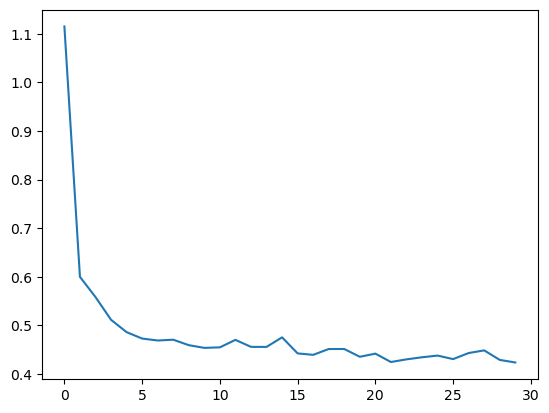

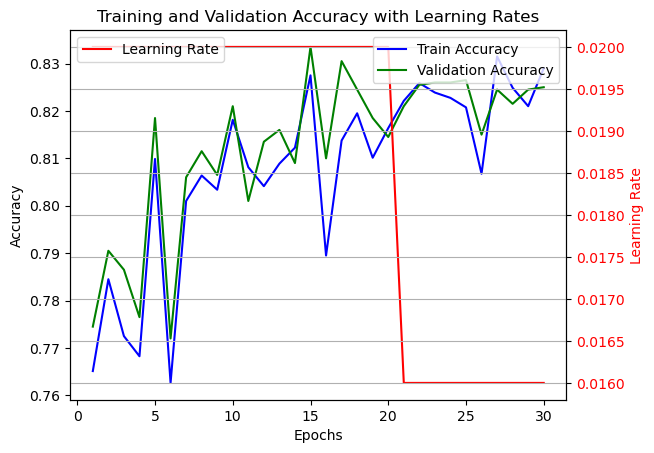

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(clf.history['loss'])
plt.show()

epochs = range(1, len(clf.history['train_accuracy']) + 1)
train_accuracy = clf.history['train_accuracy']
valid_accuracy = clf.history['valid_accuracy']
learning_rates = clf.history['lr']


fig, ax1 = plt.subplots()

# Plotting train_accuracy and valid_accuracy on the primary y-axis
ax1.plot(epochs, train_accuracy, 'b-', label='Train Accuracy', zorder=2)
ax1.plot(epochs, valid_accuracy, 'g-', label='Validation Accuracy', zorder=2)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y', labelcolor='black')

# Create a secondary y-axis for the learning rates
ax2 = ax1.twinx()
ax2.plot(epochs, learning_rates, 'r-', label='Learning Rate', zorder=1)
ax2.set_ylabel('Learning Rate', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Adding legends (making sure both ar above plots (zorder)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
first_legend = plt.legend(handles1, labels1, loc='upper right')
ax2.add_artist(first_legend)
ax2.legend(handles2, labels2, loc='upper left')

# Show grid and plot
plt.grid(True)
plt.title('Training and Validation Accuracy with Learning Rates')
plt.show()

In [24]:
clf.predict_proba(X_valid)

array([[8.35684924e-11, 7.88313557e-08, 1.10517125e-04, 9.99889374e-01],
       [5.71286670e-13, 5.69568448e-10, 3.57970725e-06, 9.99996424e-01],
       [6.74554259e-02, 1.96318299e-01, 2.82912880e-01, 4.53313440e-01],
       ...,
       [6.87348321e-02, 3.54554296e-01, 3.76041651e-01, 2.00669229e-01],
       [7.97084613e-06, 1.98343210e-03, 1.05365805e-01, 8.92642796e-01],
       [4.68859040e-09, 1.48286872e-05, 3.24799446e-03, 9.96737182e-01]],
      dtype=float32)

In [25]:
import numpy as np
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_valid) # I know, measuring model perf' on valid dataset is stooop'
display(y_pred)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_valid)

print(f"BEST VALID SCORE : {clf.best_cost}")
print(f"FINAL TEST SCORE : {test_acc}")

array(['class_3', 'class_3', 'class_3', ..., 'class_2', 'class_3',
       'class_3'], dtype='<U7')

BEST VALID SCORE : 0.8335
FINAL TEST SCORE : 0.8335


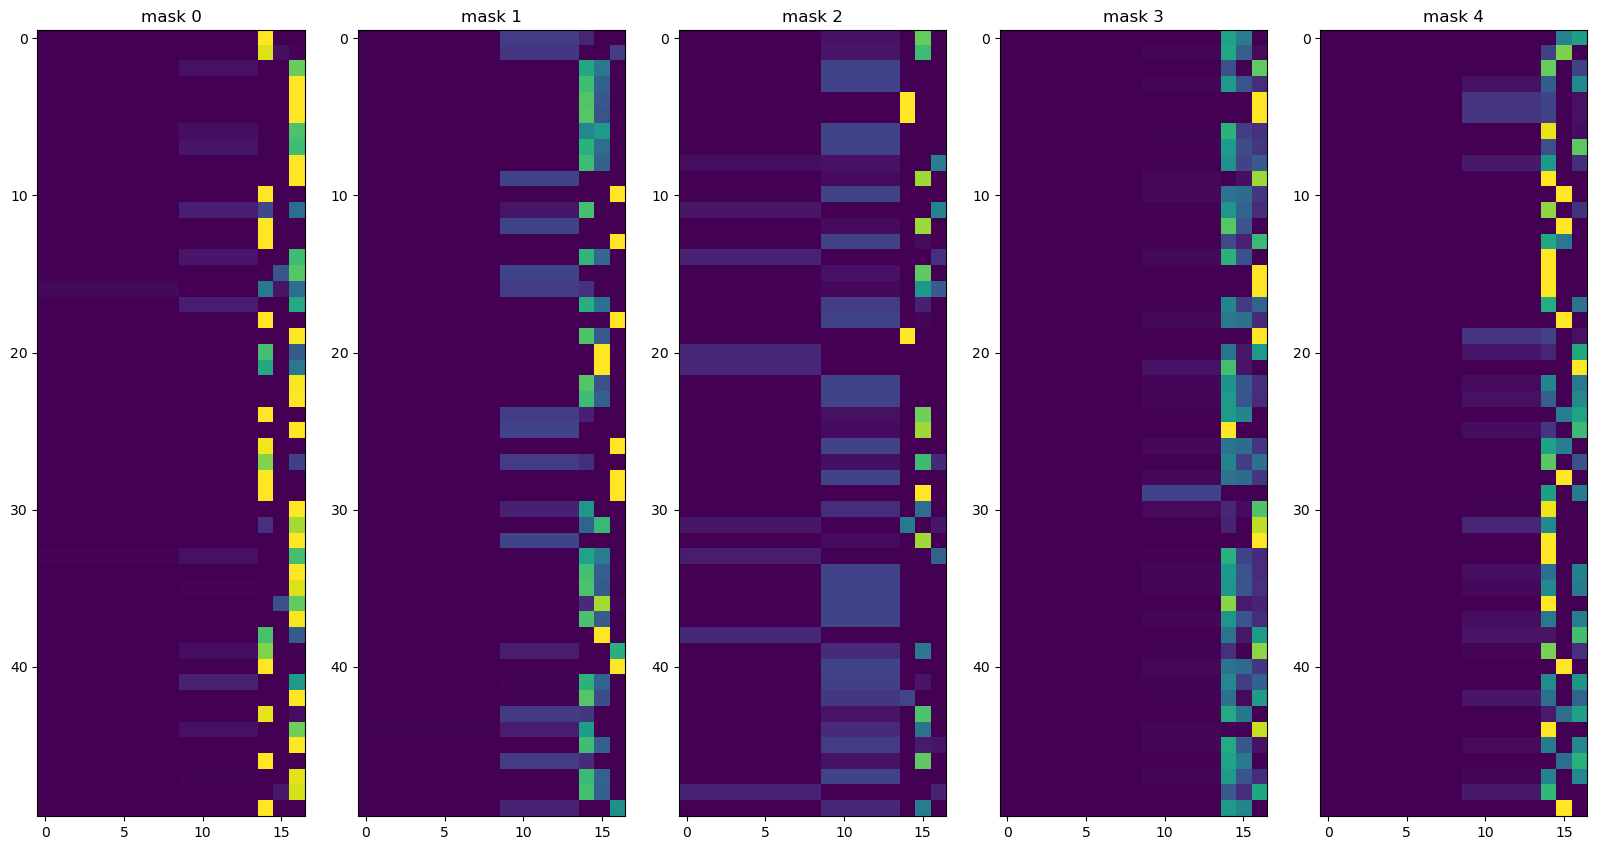

In [26]:
explain_matrix, masks = clf.explain(X_valid) # change to holdout dataset here too

fig, axs = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [27]:
y_pred

array(['class_2', 'class_0', 'class_0', ..., 'class_2', 'class_2',
       'class_3'], dtype='<U7')

In [28]:
X_valid.shape

(2000, 12)

In [29]:
clf.feature_importances_

array([0.02121709, 0.02121709, 0.02121709, 0.02121709, 0.04760441,
       0.04760441, 0.04760441, 0.04760441, 0.04760441, 0.1187497 ,
       0.42452973, 0.13383015])

In [30]:
clf.grouped_features

[[0, 1, 2, 3], [4, 5, 6, 7, 8]]

In [31]:
import inspect
from pytorch_tabnet.callbacks import Callback
inspect.getsource(Callback)

'class Callback:\n    """\n    Abstract base class used to build new callbacks.\n    """\n\n    def __init__(self):\n        pass\n\n    def set_params(self, params):\n        self.params = params\n\n    def set_trainer(self, model):\n        self.trainer = model\n\n    def on_epoch_begin(self, epoch, logs=None):\n        pass\n\n    def on_epoch_end(self, epoch, logs=None):\n        pass\n\n    def on_batch_begin(self, batch, logs=None):\n        pass\n\n    def on_batch_end(self, batch, logs=None):\n        pass\n\n    def on_train_begin(self, logs=None):\n        pass\n\n    def on_train_end(self, logs=None):\n        pass\n'

<hr />

# Metaflow Run

Chosse which domain shall be considered for the HP tuning grid search&nbsp;:

In [1]:
pipeline_hp_grid = {
    "trainer": {
        "max_epochs":[100], #sys.maxsize,
        "patience":[10],
        "batch_size":[1024],
        "virtual_batch_size":[256],
    },
    "model": {
        "n_d":[64],
        "n_a":[64],
        "n_steps":[6],
        "gamma":[1.5],
        "n_independent":[2],
        "n_shared":[2],
        "lambda_sparse":[1e-4],
        "momentum":[0.3],
        "clip_value":[2.],
        "optimizer_fn":["torch.optim.Adam"],
        "optimizer_params":[dict(lr=2e-2), dict(lr=0.1)],
        "scheduler_params":[{"gamma": 0.80,
                            "step_size": 20}],
        "scheduler_fn":["torch.optim.lr_scheduler.StepLR"],
        "epsilon":[1e-15]
    }
}
from textwrap import dedent
os.environ['pipeline_hp_grid'] = str(json.dumps(dedent("""{pipeline_hp_grid}""".format(pipeline_hp_grid=pipeline_hp_grid)))).replace("'", '"').strip('"')
print(os.environ['pipeline_hp_grid'])

{"trainer": {"max_epochs": [100], "patience": [10], "batch_size": [1024], "virtual_batch_size": [256]}, "model": {"n_d": [64], "n_a": [64], "n_steps": [6], "gamma": [1.5], "n_independent": [2], "n_shared": [2], "lambda_sparse": [0.0001], "momentum": [0.3], "clip_value": [2.0], "optimizer_fn": ["torch.optim.Adam"], "optimizer_params": [{"lr": 0.02}, {"lr": 0.1}], "scheduler_params": [{"gamma": 0.8, "step_size": 20}], "scheduler_fn": ["torch.optim.lr_scheduler.StepLR"], "epsilon": [1e-15]}}


## Run flow

In [2]:
%reload_ext retrain_pipelines.local_launcher_magic

In [ ]:
%retrain_pipelines_local retraining_pipeline.py run --help

In [3]:
%retrain_pipelines_local retraining_pipeline.py run \
    --data_file "../data/synthetic_classif_tab_data_4classes.csv" \
    --buckets_param '{"num_feature2": 100, "num_feature4": 50}' \
    --pipeline_hp_grid "${pipeline_hp_grid}" \
    --cv_folds 2 \
    --wandb_run_mode disabled
    #--preprocess_artifacts_path "." \
    #--pipeline_card_artifacts_path "." \

 retrain-pipelines 0.0.0 
Metaflow 2.10.0 executing TabNetHpCvWandbFlow for user:organization
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint not found, so extra checks are disabled.
Including file /mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/sample_pipelines/TabNet_hp_cv_WandB/../data/synthetic_classif_tab_data_4classes.csv of size 315KB 
2024-09-21 14:15:43.672 Workflow starting (run-id 973):
2024-09-21 14:15:44.089 [973/start/29573 (pid 10856)] Task is starting.
2024-09-21 14:15:47.264 [973/start/29573 (pid 10856)] TabNetHpCvWandbFlow - 973
2024-09-21 14:15:47.265 [973/start/29573 (pid 10856)] /home/organization/local_datastore/.metaflow/TabNetHpCvWandbFlow/973
2024-09-21 14:15:49.187 [973/start/29573 (pid 10856)] Task finished successfully.
2024-09-21 14:15:49.568 [973/eda/29574 (pid 10875)] Task is starting.
2024-09-21 14:15:55.187 [973/eda/29574 (pid 10875)] Task finished successfully.
2024-09-21 14:15:55.466 [973/preprocess_data/29575 (pid 109

2024-09-21 14:16:20.189 [973/training_job/29582 (pid 11069)] Task is starting.
2024-09-21 14:16:20.610 [973/training_job/29583 (pid 11080)] Task is starting.
2024-09-21 14:16:24.315 [973/training_job/29580 (pid 11032)] cross_validation 29578
2024-09-21 14:16:24.317 [973/training_job/29580 (pid 11032)] hyperparameter values : {'trainer': {'max_epochs': 100, 'patience': 10, 'batch_size': 1024, 'virtual_batch_size': 256}, 'model': {'n_d': 64, 'n_a': 64, 'n_steps': 6, 'gamma': 1.5, 'n_independent': 2, 'n_shared': 2, 'lambda_sparse': 0.0001, 'momentum': 0.3, 'clip_value': 2.0, 'optimizer_fn': <class 'torch.optim.adam.Adam'>, 'optimizer_params': {'lr': 0.02}, 'scheduler_params': {'gamma': 0.8, 'step_size': 20}, 'scheduler_fn': <class 'torch.optim.lr_scheduler.StepLR'>, 'epsilon': 1e-15}}
2024-09-21 14:16:24.345 [973/training_job/29581 (pid 11043)] cross_validation 29578
2024-09-21 14:16:24.348 [973/training_job/29581 (pid 11043)] hyperparameter values : {'trainer': {'max_epochs': 100, 'patie

2024-09-21 14:16:36.255 [973/training_job/29583 (pid 11080)] epoch 6  | loss: 0.80665 | Training_accuracy: 0.43075 | Validation_accuracy: 0.417   |  0:00:10s
2024-09-21 14:16:37.010 [973/training_job/29580 (pid 11032)] epoch 7  | loss: 0.81118 | Training_accuracy: 0.40638 | Validation_accuracy: 0.388   |  0:00:12s
2024-09-21 14:16:37.428 [973/training_job/29582 (pid 11069)] epoch 7  | loss: 0.889   | Training_accuracy: 0.51413 | Validation_accuracy: 0.507   |  0:00:12s
2024-09-21 14:16:37.439 [973/training_job/29581 (pid 11043)] epoch 7  | loss: 0.85595 | Training_accuracy: 0.45038 | Validation_accuracy: 0.4395  |  0:00:12s
2024-09-21 14:16:37.508 [973/training_job/29583 (pid 11080)] epoch 7  | loss: 0.77076 | Training_accuracy: 0.49762 | Validation_accuracy: 0.4795  |  0:00:12s
2024-09-21 14:16:38.320 [973/training_job/29580 (pid 11032)] epoch 8  | loss: 0.78604 | Training_accuracy: 0.3825  | Validation_accuracy: 0.372   |  0:00:13s
2024-09-21 14:16:38.899 [973/training_job/29582 (pid

2024-09-21 14:16:52.835 [973/training_job/29582 (pid 11069)] epoch 17 | loss: 0.76183 | Training_accuracy: 0.50838 | Validation_accuracy: 0.4965  |  0:00:27s
2024-09-21 14:16:53.603 [973/training_job/29581 (pid 11043)] epoch 18 | loss: 0.74956 | Training_accuracy: 0.48588 | Validation_accuracy: 0.4715  |  0:00:28s
2024-09-21 14:16:53.773 [973/training_job/29583 (pid 11080)] epoch 18 | loss: 0.73673 | Training_accuracy: 0.49012 | Validation_accuracy: 0.473   |  0:00:28s
2024-09-21 14:16:54.064 [973/training_job/29580 (pid 11032)] Task finished successfully.
2024-09-21 14:16:54.311 [973/training_job/29582 (pid 11069)] epoch 18 | loss: 0.75964 | Training_accuracy: 0.53038 | Validation_accuracy: 0.529   |  0:00:29s
2024-09-21 14:16:54.901 [973/training_job/29581 (pid 11043)] epoch 19 | loss: 0.73574 | Training_accuracy: 0.55612 | Validation_accuracy: 0.532   |  0:00:30s
2024-09-21 14:16:55.125 [973/training_job/29583 (pid 11080)] epoch 19 | loss: 0.73087 | Training_accuracy: 0.53788 | Vali

2024-09-21 14:17:13.019 [973/training_job/29581 (pid 11043)] epoch 42 | loss: 0.67263 | Training_accuracy: 0.53212 | Validation_accuracy: 0.5255  |  0:00:48s
2024-09-21 14:17:13.629 [973/training_job/29581 (pid 11043)] epoch 43 | loss: 0.6694  | Training_accuracy: 0.507   | Validation_accuracy: 0.5     |  0:00:48s
2024-09-21 14:17:14.216 [973/training_job/29581 (pid 11043)] epoch 44 | loss: 0.66786 | Training_accuracy: 0.63925 | Validation_accuracy: 0.626   |  0:00:49s
2024-09-21 14:17:14.782 [973/training_job/29581 (pid 11043)] epoch 45 | loss: 0.68605 | Training_accuracy: 0.62113 | Validation_accuracy: 0.6075  |  0:00:49s
2024-09-21 14:17:15.386 [973/training_job/29581 (pid 11043)] epoch 46 | loss: 0.67581 | Training_accuracy: 0.64738 | Validation_accuracy: 0.6225  |  0:00:50s
2024-09-21 14:17:15.991 [973/training_job/29581 (pid 11043)] epoch 47 | loss: 0.67787 | Training_accuracy: 0.64275 | Validation_accuracy: 0.6135  |  0:00:51s
2024-09-21 14:17:16.592 [973/training_job/29581 (pid

2024-09-21 14:17:40.210 [973/training_job/29581 (pid 11043)] epoch 87 | loss: 0.61765 | Training_accuracy: 0.74762 | Validation_accuracy: 0.7205  |  0:01:15s
2024-09-21 14:17:40.793 [973/training_job/29581 (pid 11043)] epoch 88 | loss: 0.6201  | Training_accuracy: 0.74925 | Validation_accuracy: 0.714   |  0:01:16s
2024-09-21 14:17:41.370 [973/training_job/29581 (pid 11043)] epoch 89 | loss: 0.61058 | Training_accuracy: 0.74625 | Validation_accuracy: 0.71    |  0:01:16s
2024-09-21 14:17:41.969 [973/training_job/29581 (pid 11043)] epoch 90 | loss: 0.62295 | Training_accuracy: 0.74638 | Validation_accuracy: 0.721   |  0:01:17s
2024-09-21 14:17:42.621 [973/training_job/29581 (pid 11043)] epoch 91 | loss: 0.61255 | Training_accuracy: 0.74412 | Validation_accuracy: 0.715   |  0:01:17s
2024-09-21 14:17:43.214 [973/training_job/29581 (pid 11043)] epoch 92 | loss: 0.62247 | Training_accuracy: 0.74462 | Validation_accuracy: 0.718   |  0:01:18s
2024-09-21 14:17:43.761 [973/training_job/29581 (pid

2024-09-21 14:18:23.120 [973/train_model/29587 (pid 11363)] epoch 20 | loss: 0.70181 | Training_accuracy: 0.63938 | Validation_accuracy: 0.6205  |  0:00:17s
2024-09-21 14:18:23.998 [973/train_model/29587 (pid 11363)] epoch 21 | loss: 0.68558 | Training_accuracy: 0.64375 | Validation_accuracy: 0.6215  |  0:00:18s
2024-09-21 14:18:24.842 [973/train_model/29587 (pid 11363)] epoch 22 | loss: 0.69013 | Training_accuracy: 0.66825 | Validation_accuracy: 0.6485  |  0:00:19s
2024-09-21 14:18:25.706 [973/train_model/29587 (pid 11363)] epoch 23 | loss: 0.69042 | Training_accuracy: 0.65162 | Validation_accuracy: 0.633   |  0:00:20s
2024-09-21 14:18:26.562 [973/train_model/29587 (pid 11363)] epoch 24 | loss: 0.68288 | Training_accuracy: 0.67212 | Validation_accuracy: 0.658   |  0:00:21s
2024-09-21 14:18:27.448 [973/train_model/29587 (pid 11363)] epoch 25 | loss: 0.68513 | Training_accuracy: 0.67812 | Validation_accuracy: 0.67    |  0:00:22s
2024-09-21 14:18:28.435 [973/train_model/29587 (pid 11363)

2024-09-21 14:19:05.484 [973/train_model/29587 (pid 11363)] epoch 65 | loss: 0.61785 | Training_accuracy: 0.781   | Validation_accuracy: 0.752   |  0:01:00s
2024-09-21 14:19:06.416 [973/train_model/29587 (pid 11363)] epoch 66 | loss: 0.61883 | Training_accuracy: 0.78388 | Validation_accuracy: 0.7505  |  0:01:01s
2024-09-21 14:19:07.306 [973/train_model/29587 (pid 11363)] epoch 67 | loss: 0.61842 | Training_accuracy: 0.781   | Validation_accuracy: 0.7505  |  0:01:01s
2024-09-21 14:19:07.315 [973/train_model/29587 (pid 11363)] 
2024-09-21 14:19:07.793 [973/train_model/29587 (pid 11363)] Early stopping occurred at epoch 67 with best_epoch = 57 and best_Validation_accuracy = 0.753
2024-09-21 14:19:07.793 [973/train_model/29587 (pid 11363)] subset of true positives for 'class_0' : 10
2024-09-21 14:19:07.976 [973/train_model/29587 (pid 11363)] Warning: tight_layout may not be fully compatible with all Axes.
2024-09-21 14:19:07.976 [973/train_model/29587 (pid 11363)] fig dims : [7.    3.075]


In [ ]:
%retrain_pipelines_local retraining_pipeline.py resume pipeline_card

# Inspectors

After the fact inspecting retraining pipelines runs.

## local Metaflow SDK

In [6]:
from retrain_pipelines.frameworks import local_metaflow as metaflow

In [9]:
metaflow.Task("TabNetHpCvWandbFlow/973/pipeline_card/29591",  attempt=0)['model'].data

TabNetClassifier(n_d=64, n_a=64, n_steps=6, gamma=1.5, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.3, lambda_sparse=0.0001, seed=0, clip_value=2.0, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'gamma': 0.8, 'step_size': 20}, mask_type='sparsemax', input_dim=75, output_dim=4, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70], [71, 72]])

## local custom card explorer

Retrieve the full path to the custom html pipeline card in the local datastore&nbsp;:

In [4]:
from retrain_pipelines.inspectors import browse_local_pipeline_card

In [5]:
browse_local_pipeline_card(mf_flow_name)
#browse_local_pipeline_card(mf_run_id=800, verbose=True)

<hr />

# WandB

Make sure to have the `WANDB_API_KEY` environement variable set adequately.<br />
It can be through a `secret`.

<b>programmatically browse the saved source-code</b>

In [17]:
from retrain_pipelines.inspectors import get_execution_source_code

for source_code_artifact in get_execution_source_code(mf_run_id=860): #mf_flow_name):
    print(f" - {source_code_artifact.name} {source_code_artifact.url}")

v12 ; 2024-09-17T13:14:01Z
 - retraining_pipeline.py


<b>The below command will download source-code artifacts for a given run and open a file explorer on the parent dir&nbsp;:</b>

In [18]:
from retrain_pipelines.inspectors import explore_source_code

explore_source_code(mf_flow_name=mf_flow_name)

/mnt/d/jupyter_notebooks/job_hunt/AWS/fresh_start/sample_pipelines/TabNet_hp_cv_WandB/TabNetHpCvWandbFlow_860
v12 ; 2024-09-17T13:14:01Z


<hr />

# dependencies

In [ ]:
%pip list

In [ ]:
%pip list --format=freeze > requirements.txt

# debug zone

In [ ]:
for artifact_name in model_card_task.artifacts:
    print(f"{artifact_name}")

In [ ]:
print(pipeline_card_task['html'].data[:2000])

In [ ]:
custom_card.path

In [ ]:
custom_card.__dict__.keys()

In [ ]:
custom_card._card_ds.get_storage_root(storage_type='local')

In [ ]:
metaflow.metaflow_config.CARD_SUFFIX

In [ ]:
ds_root = pipeline_card_task.metadata_dict.get("ds-root", None)
ds_type, ds_root

In [ ]:
%ls $ds_root/mf.cards/$pipeline_card_task.parent.parent.parent.id/runs/$pipeline_card_task.parent.parent.id/tasks/$pipeline_card_task.parent.task.id/cards/

In [ ]:
pipeline_card_task.metadata_dict

In [ ]:
storage_impl = [d for d in metaflow.plugins.DATASTORES if d.TYPE == ds_type][0]
storage_impl

<hr width=50% />

In [ ]:
for flow in metaflow.Metaflow():
    print(flow)
    for run in flow.runs():
        print(f"  Run ID: {run.id}")
        print(f"  Steps: {[str(step) for step in run.steps()]}")

In [ ]:
flows = list(metaflow.Metaflow())
if flows:
    first_flow = flows[0]

    # Get the last run from the first flow
    last_run = list(first_flow.runs())[0]

    # Print details of the last run
    print(f"Flow: {first_flow.id}")
    print(f"Last Run ID: {last_run.id}")
    print(f"Start Time: {last_run.created_at}")
    print(f"Status: {last_run.successful}")
    for step in last_run.steps():
        print(f"Step: {step.id}")
        print(step.task)